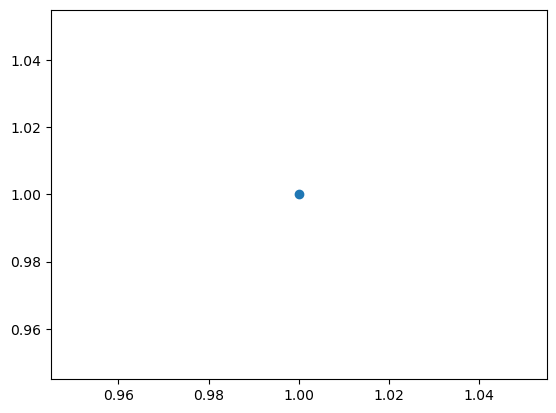

In [1]:
import matplotlib.pyplot as plt
plt.scatter(1,1)

In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np

<div style="font-size:32px; line-height:1.4;">
    <b>Этап 1 предобучение авто-кодировщика:</b><br>
</div>

In [3]:
main_dir = 'datasets'
set_dir = 'IMAGENET100'
train_dir = 'train'
test_dir = 'test'

In [234]:
class SparseCAE_layer05 (nn.Module):
    def __init__(self, in_ch, sparsity_lambda=1e-3):
        super().__init__()
        
        self.sparsity_lambda = sparsity_lambda
        self.bn3n = nn.BatchNorm2d(2*in_ch)
        
        self.encoder = nn.Conv2d(in_ch, 2*in_ch, kernel_size=4, stride=2, padding=1)
        self.decoder = nn.ConvTranspose2d(2*in_ch, in_ch, kernel_size=4, stride=2, padding=1)
        
    def forward(self, X):     

        X = torch.relu(self.bn3n(self.encoder(X)))
        X = torch.relu(self.decoder(X))
        
        return X
        
    def encode(self, X):
        return torch.relu(self.bn3n(self.encoder(X)))
        
    def decode(self, X):
        return torch.relu(self.decoder(X))
        
    def loss_function(self, x, decoded, encoded):
        
        recon_loss = F.mse_loss(decoded, x, reduction='mean')
        sparsity_loss = torch.mean(torch.abs(encoded))
        return recon_loss + self.sparsity_lambda * sparsity_loss

In [236]:
train_transforms = transforms.Compose([
                                       transforms.Resize((64, 64)),
                                       transforms.ToTensor()
                                      ])
test_transforms = train_transforms

TRAIN_DATA = datasets.ImageFolder(os.path.join(main_dir, set_dir, train_dir), transform=train_transforms)
TEST_DATA = datasets.ImageFolder(os.path.join(main_dir, set_dir, test_dir), transform=test_transforms)

In [361]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SparseCAE_layer05(48).to(device)
epoche = 0

In [362]:
epochs = 1000000
learning_rate = 0.03
optimizer = torch.optim.RAdam(model.parameters(), learning_rate, weight_decay=0.0001)

BATCH_SIZE = 64#len(TEST_DATA)
           
train_loader = torch.utils.data.DataLoader(TRAIN_DATA, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(TEST_DATA, batch_size=BATCH_SIZE, shuffle=True)

In [363]:
model.train()

#parent_model = None
parent_model = combined_model

if parent_model == None:
    for cur in range(epochs):
        epoche += 1 
        
        for x, _ in train_loader:
            inputs, labels = x.to(device), x.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss = model.loss_function(labels, outputs, model.encode(inputs))
            
            loss.backward()
            optimizer.step()
        
            print(f"Эпоха: {epoche} , ошибка  {loss}",
                  sep='', end='\r')
            
if parent_model != None:    
    for cur in range(epochs):
        epoche += 1 
        
        for x, _ in train_loader:
            inputs, labels = parent_model.encode(x.to(device)), parent_model.encode(x.to(device))
            optimizer.zero_grad()
            outputs = model(inputs)
            
            loss= model.loss_function(labels, outputs, model.encode(inputs))
            
            loss.backward()
            optimizer.step()
        
            print(f"Эпоха: {epoche} , ошибка  {loss}",
                  sep='', end='\r')

KeyboardInterrupt: 

In [364]:
#layer1 = model
#layer2 = model
#layer3 = model
#layer4 = model
#layer5 = model

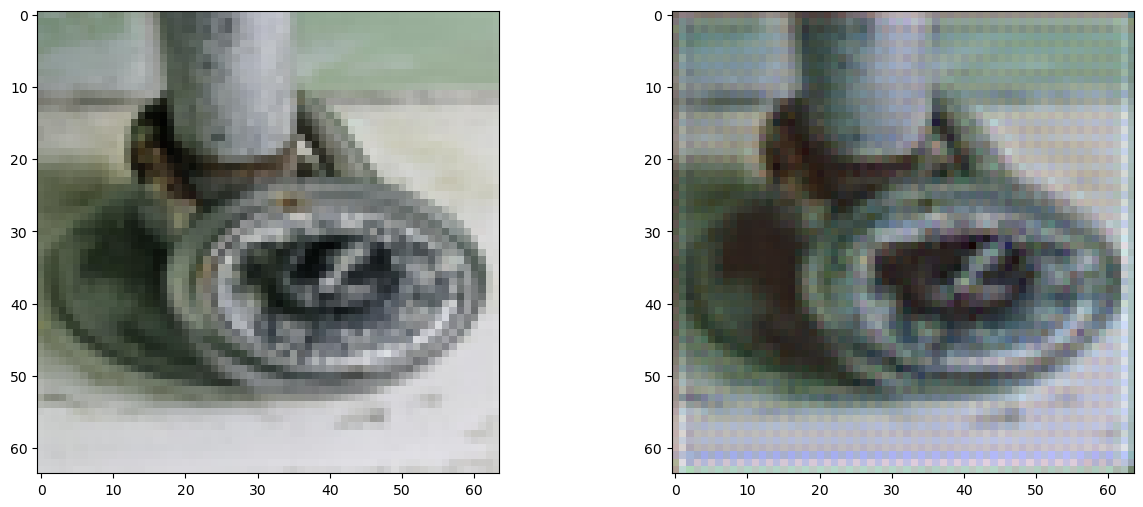

In [246]:
model.eval()
rnd_im = TRAIN_DATA[np.random.randint(0, len(TRAIN_DATA))][0]
ans = model(rnd_im.unsqueeze(0).to(device))[0].cpu().detach()
ans = np.array(ans.view(3,64,64)).transpose((1, 2, 0))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[1].imshow(ans)
ax[0].imshow(np.transpose(rnd_im, (1,2,0)))

In [285]:
class StackedAE (nn.Module):
    def __init__(self,
                 layer1,
                 layer2,
                 sparsity_lambda=1e-3):
        super().__init__()
        
        self.sparsity_lambda = sparsity_lambda
        
        self.layer1 = layer1
        self.layer2 = layer2
        
    def forward(self, X):     

        X = self.layer1.encode(X)
        X = self.layer2(X)
        X = self.layer1.decode(X)
        
        return X
        
    def encode(self, X):
        
        X = self.layer1.encode(X)
        X = self.layer2.encode(X)
        
        return X
        
    def decode(self, X):
        
        X = self.layer2.decode(X)
        X = self.layer1.decode(X)
        
        return X 
        
    def loss_function(self, x, decoded, encoded):
        
        recon_loss = F.mse_loss(decoded, x, reduction='mean')
        sparsity_loss = torch.mean(torch.abs(encoded))
        return recon_loss + self.sparsity_lambda * sparsity_loss
        
combined_model = StackedAE(layer1, layer2)

In [328]:
class StackedAE3 (nn.Module):
    def __init__(self,
                 layer1,
                 layer2,
                 layer3,
                 sparsity_lambda=1e-3):
        super().__init__()
        
        self.sparsity_lambda = sparsity_lambda
        
        self.layer1 = layer1
        self.layer2 = layer2
        self.layer3 = layer3
        
    def forward(self, X):     

        X = self.layer1.encode(X)
        X = self.layer2.encode(X)
        X = self.layer3(X)
        X = self.layer2.decode(X)
        X = self.layer1.decode(X)
        
        return X
        
    def encode(self, X):
        
        X = self.layer1.encode(X)
        X = self.layer2.encode(X)
        X = self.layer3.encode(X)
        return X
        
    def decode(self, X):
        
        X = self.layer3.decode(X)
        X = self.layer2.decode(X)
        X = self.layer1.decode(X)
        
        return X 
        
    def loss_function(self, x, decoded, encoded):
        
        recon_loss = F.mse_loss(decoded, x, reduction='mean')
        sparsity_loss = torch.mean(torch.abs(encoded))
        return recon_loss + self.sparsity_lambda * sparsity_loss
        
combined_model = StackedAE3(layer1, layer2, layer3)

In [392]:
class StackedAE4 (nn.Module):
    def __init__(self,
                 layer1,
                 layer2,
                 layer3,
                 layer4,
                 sparsity_lambda=1e-3):
        super().__init__()
        
        self.sparsity_lambda = sparsity_lambda
        
        self.layer1 = layer1
        self.layer2 = layer2
        self.layer3 = layer3
        self.layer4 = layer4
        
    def forward(self, X):     

        X = self.layer1.encode(X)
        X = self.layer2.encode(X)
        X = self.layer3.encode(X)
        X = self.layer4(X)
        X = self.layer3.decode(X)
        X = self.layer2.decode(X)
        X = self.layer1.decode(X)
        
        return X
        
    def encode(self, X):
        
        X = self.layer1.encode(X)
        X = self.layer2.encode(X)
        X = self.layer3.encode(X)
        X = self.layer4.encode(X)
        
        return X
        
    def decode(self, X):
        
        X = self.layer4.decode(X)
        X = self.layer3.decode(X)
        X = self.layer2.decode(X)
        X = self.layer1.decode(X)
        
        return X 
        
    def loss_function(self, x, decoded, encoded):
        
        recon_loss = F.mse_loss(decoded, x, reduction='mean')
        sparsity_loss = torch.mean(torch.abs(encoded))
        return recon_loss + self.sparsity_lambda * sparsity_loss
        
combined_model = StackedAE4(layer1, layer2, layer3, layer4)

In [397]:
class StackedAE5 (nn.Module):
    def __init__(self,
                 layer1,
                 layer2,
                 layer3,
                 layer4,
                 layer5,
                 sparsity_lambda=1e-3):
        super().__init__()
        
        self.sparsity_lambda = sparsity_lambda
        
        self.layer1 = layer1
        self.layer2 = layer2
        self.layer3 = layer3
        self.layer4 = layer4
        self.layer5 = layer5
        
    def forward(self, X):     

        X = self.encode(X)
        X = self.decode(X)
        
        return X
        
    def encode(self, X):
        
        X = self.layer1.encode(X)
        X = self.layer2.encode(X)
        X = self.layer3.encode(X)
        X = self.layer4.encode(X)
        X = self.layer5.encode(X)
        
        return X
        
    def decode(self, X):
        
        X = self.layer5.decode(X)
        X = self.layer4.decode(X)
        X = self.layer3.decode(X)
        X = self.layer2.decode(X)
        X = self.layer1.decode(X)
        
        return X 
        
    def loss_function(self, x, decoded, encoded):
        
        recon_loss = F.mse_loss(decoded, x, reduction='mean')
        sparsity_loss = torch.mean(torch.abs(encoded))
        return recon_loss + self.sparsity_lambda * sparsity_loss
        
combined_model = StackedAE5(layer1, layer2, layer3, layer4, layer5)

In [399]:
epochs = 1000000
learning_rate = 0.0001
cm_optimizer = torch.optim.RAdam(combined_model.parameters(), learning_rate, weight_decay=0.0001)

BATCH_SIZE = 64#len(TEST_DATA)
           
train_loader = torch.utils.data.DataLoader(TRAIN_DATA, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(TEST_DATA, batch_size=BATCH_SIZE, shuffle=True)

In [400]:
for cur in range(epochs):
        epoche += 1 
        
        for x, _ in train_loader:
            inputs, labels = x.to(device), x.to(device)
            cm_optimizer.zero_grad()
            outputs = combined_model(inputs)
    
            loss = combined_model.loss_function(labels, outputs, combined_model.encode(inputs))
        
            loss.backward()
            cm_optimizer.step()
        
            print(f"Эпоха: {epoche} , ошибка  {loss}",
                  sep='', end='\r')

KeyboardInterrupt: 

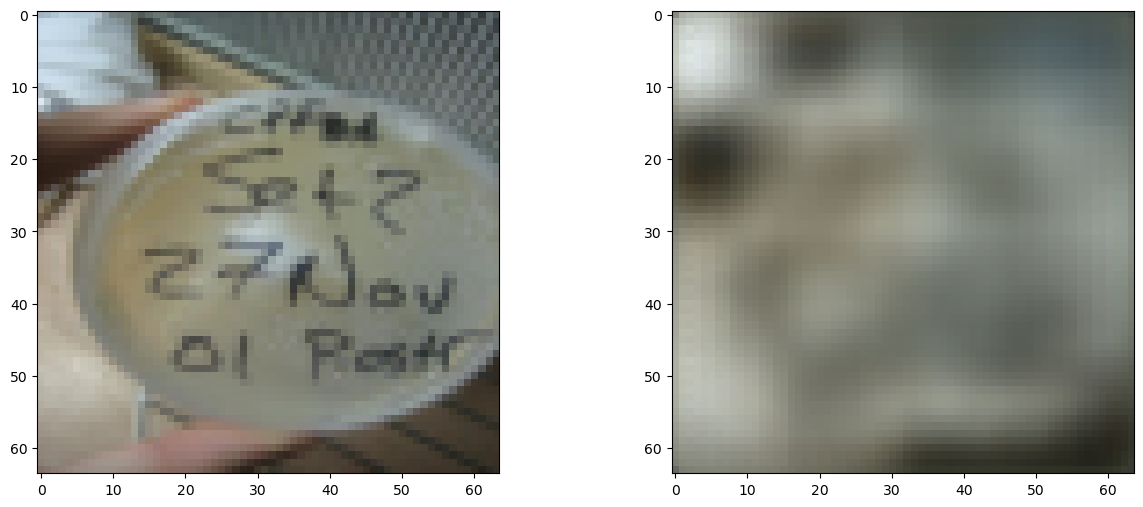

In [410]:
combined_model.eval()
rnd_im = TRAIN_DATA[np.random.randint(0, len(TRAIN_DATA))][0]
ans = combined_model(rnd_im.unsqueeze(0).to(device))[0].cpu().detach()
ans = np.array(ans.view(3,64,64)).transpose((1, 2, 0))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[1].imshow(ans)
ax[0].imshow(np.transpose(rnd_im, (1,2,0)))

In [396]:
layer1 = combined_model.layer1
layer2 = combined_model.layer2
layer3 = combined_model.layer3
layer4 = combined_model.layer4
layer5 = combined_model.layer5

In [411]:
torch.save(combined_model, 'AE_64x3_384s.pth')

<div style="font-size:32px; line-height:1.4;">
    <b>Этап 2 дообучение авто-кодировщика:</b><br>
</div>

In [4]:
main_dir_apt = 'datasets'
set_dir_apt = 'DeepCluster_ds'
train_dir_apt = 'train'

In [5]:
train_transforms = transforms.Compose([
                                       transforms.Resize((64, 64)),
                                       transforms.ToTensor()
                                      ])

TRAIN_DATA_SEC = datasets.ImageFolder(os.path.join(main_dir_apt, set_dir_apt, train_dir_apt), transform=train_transforms)

In [6]:
pretrain_model = torch.load('AE_64x3_384_012.pth', weights_only=False)
pretrain_model.eval()
epoche = 0

AttributeError: Can't get attribute 'Sparce_FDSCAE' on <module '__main__'>

In [432]:
epochs = 1000000
learning_rate = 0.01
optimizer = torch.optim.RAdam(pretrain_model.parameters(), learning_rate, weight_decay=0.0001)

BATCH_SIZE = 8#len(TEST_DATA)
           
train_loader = torch.utils.data.DataLoader(TRAIN_DATA_SEC, batch_size=BATCH_SIZE, shuffle=True)

In [433]:
for cur in range(epochs):
    epoche += 1 
    
    for x, _ in train_loader:
        inputs, labels = x.to(device), x.to(device)
        optimizer.zero_grad()
        outputs = pretrain_model(inputs)

        loss= pretrain_model.loss_function(labels, outputs, pretrain_model.encode(inputs))
    
        loss.backward()
        optimizer.step()
    
        print(f"Эпоха: {epoche} , ошибка  {loss}",
              sep='', end='\r')

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


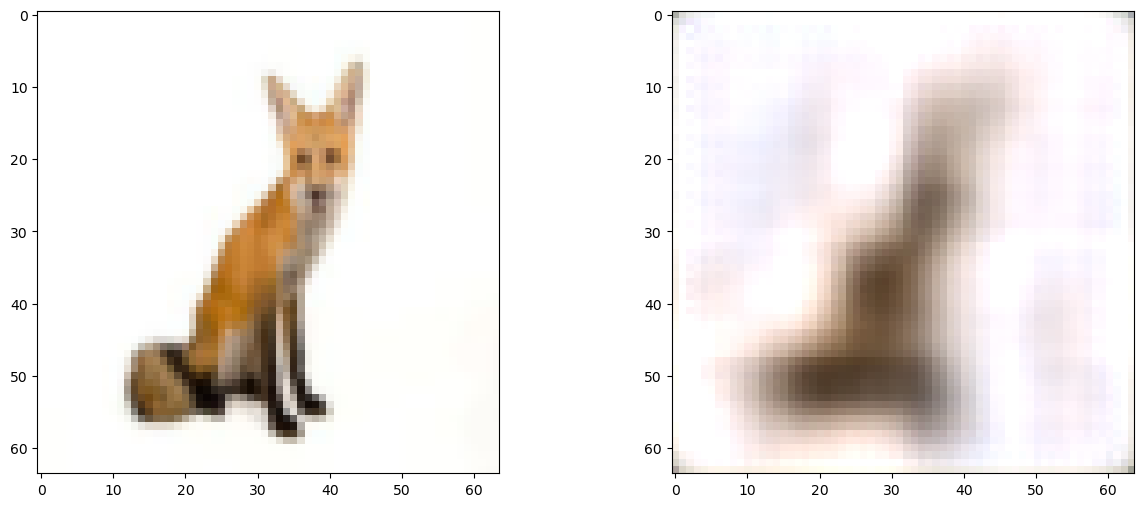

In [435]:
rnd_im = TRAIN_DATA_SEC[np.random.randint(0, len(TRAIN_DATA_SEC))][0]
ans = pretrain_model(rnd_im.unsqueeze(0).to(device))[0].cpu().detach()
ans = np.array(ans.view(3,64,64)).transpose((1, 2, 0))

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[1].imshow(ans)
ax[0].imshow(np.transpose(rnd_im, (1,2,0)))

<div style="font-size:32px; line-height:1.4;">
    <b>Этап 3 обучение кластеризатора:</b><br>
</div>

In [438]:
class DeepImageCluster(nn.Module):
    def __init__(self, inheritance_AE, centroids):
        super().__init__()
        
        self.n_cluster = len(centroids)
        self.centroids = centroids
       
        self.C1 = inheritance_AE.layer1.encoder
        self.C2 = inheritance_AE.layer2.encoder
        self.C3 = inheritance_AE.layer3.encoder
        self.C4 = inheritance_AE.layer4.encoder
        self.C5 = inheritance_AE.layer5.encoder

    def forward(self, X):     
 
        return X,

    def loss_function(self, u):
        
        return -torch.sum(u)

In [439]:
DC_model = DeepImageCluster(pretrain_model, 3)

In [268]:
epochs = 1000000
learning_rate = 0.000000001
optimizer = torch.optim.RAdam(DC_model.parameters(), learning_rate, weight_decay=0.0001)

BATCH_SIZE = len(TRAIN_DATA_SEC)
           
train_loader = torch.utils.data.DataLoader(TRAIN_DATA_SEC, batch_size=BATCH_SIZE, shuffle=True)

In [269]:
for cur in range(epochs):
    epoche += 1 
    
    for x, _ in train_loader:
        inputs, labels = x.to(device), x.to(device)
        optimizer.zero_grad()
        embeding, probs = DC_model(inputs)

        loss= DC_model.loss_function(probs)
    
        loss.backward()
        optimizer.step()
    
        print(f"Эпоха: {epoche} , ошибка  {loss}",
              sep='', end='\r')

KeyboardInterrupt: 

In [272]:
rnd_im = TRAIN_DATA_SEC[np.random.randint(0, len(TRAIN_DATA_SEC))][0]
_, ans = DC_model(rnd_im.unsqueeze(0).to(device))[0].cpu().detach()


plt.imshow(np.transpose(rnd_im, (1,2,0)))

RuntimeError: cdist only supports at least 2D tensors, X1 got: 1D